<a href="https://colab.research.google.com/github/SamarthAdat/PixelCNN/blob/main/PixelCNN_for_RGB_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PixelCNN for RGB images.
**Description:** PixelCNN implemented in Keras.

## Introduction

It is designed to generate images (or other data types) iteratively
from an input vector where the probability distribution of prior elements dictates the
probability distribution of later elements. In the following example, images are generated
in this fashion, pixel-by-pixel, via a masked convolution kernel that only looks at data
from previously generated pixels (origin at the top left) to generate later pixels.
During inference, the output of the network is used as a probability distribution
from which new pixel values are sampled to generate a new image
here, with CIFAR10 dataset, the pixel values ranges between RGB.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm


## Getting the data


In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)
n_residual_blocks = 5
# The data, split between train and test sets
(x, _), (y, _) = keras.datasets.cifar10.load_data()
# Concatenate all the images together
data = np.concatenate((x, y), axis=0)
# Round all pixel values less than 33% of the max 256 value to 0
# anything above this value gets rounded up to 1 so that all values are either
# 0 or 1
data = data = data.astype(np.float32) / 255.0
data = data.astype(np.float32)


170498071/170498071 [==============================] - 2s 0us/step


## Create two classes for the requisite Layers for the model


In [ ]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])



## Build the model based on the original paper


In [ ]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=3, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

pixel_cnn.summary()
pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=50, validation_split=0.1, verbose=2
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 32, 32, 128)      18944     
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 32, 32, 128)      98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 32, 32, 128)      98624     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 32, 32, 128)      98624     
 lock)                                                       

## Demonstration

The PixelCNN cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.


  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 1/32 [00:10<05:35, 10.81s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 2/32 [00:16<04:01,  8.05s/it]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 3/32 [00:23<03:33,  7.35s/it]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 4/32 [00:29<03:16,  7.01s/it]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 5/32 [00:36<03:04,  6.85s/it]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 6/32 [00:42<02:48,  6.47s/it]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 7/32 [00:48<02:42,  6.49s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 8/32 [00:54<02:31,  6.33s/it]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 9/32 [01:04<02:50,  7.43s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 10/32 [01:11<02:41,  7.32s/it]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 11/32 [01:17<02:24,  6.88s/it]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 12/32 [01:25<02:22,  7.14s/it]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 13/32 [01:31<02:09,  6.81s/it]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 14/32 [01:38<02:04,  6.90s/it]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 15/32 [01:44<01:53,  6.67s/it]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 16/32 [01:51<01:46,  6.63s/it]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 17/32 [01:57<01:37,  6.49s/it]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 18/32 [02:03<01:31,  6.54s/it]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 19/32 [02:10<01:23,  6.44s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 20/32 [02:17<01:19,  6.59s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 21/32 [02:23<01:13,  6.66s/it]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 22/32 [02:31<01:08,  6.82s/it]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 23/32 [02:37<01:01,  6.82s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 24/32 [02:44<00:53,  6.68s/it]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 25/32 [02:51<00:47,  6.77s/it]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 26/32 [02:57<00:39,  6.53s/it]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 27/32 [03:03<00:32,  6.55s/it]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 28/32 [03:09<00:25,  6.37s/it]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 29/32 [03:16<00:19,  6.45s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 30/32 [03:22<00:12,  6.33s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 31/32 [03:29<00:06,  6.57s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 32/32 [03:36<00:00,  6.77s/it]


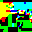

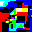

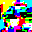

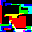

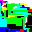

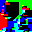

In [ ]:
from IPython.display import Image, display
from IPython.display import display, Image as IPImage
!pip install pillow
from PIL import Image

# Create an empty array of pixels.
batch = 6
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])

batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )


def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.

for i, pic in enumerate(pixels):
    if pic.shape == (32, 32, 3):
        img = Image.fromarray((pic * 255).astype(np.uint8))  # Convert to uint8 before saving
        img.save("generated_image_{}.png".format(i))
    else:
        print("Skipping image {} due to incorrect shape: {}".format(i, pic.shape))


# Display saved images
display(IPImage(filename="generated_image_0.png"))
print()
display(IPImage(filename="generated_image_1.png"))
print()
display(IPImage(filename="generated_image_2.png"))
print()
display(IPImage(filename="generated_image_3.png"))
print()
display(IPImage(filename="generated_image_4.png"))
print()
display(IPImage(filename="generated_image_5.png"))